In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import fem2d as fe
import optimutils 

Example : topology optimization of MBB beam using SIMP paradigm, minimal compliance under a volume constraint

In [2]:
nx = 16
ny = 8
mesh = fe.Mesh(nx, ny, 0, 0, 1, 2)
nelem = mesh.getNelems()
nddl = mesh.getNddlsVec()
refElem = fe.RefElement(mesh)

Beginning mesh generation...
Mesh generated!


Initialize the finite element problem

In [3]:
# Boundary conditions
dirichletnodes = np.sort(list(range(0,mesh.getNnodes(),2*nx+1)))
dirichletddls = np.sort(mesh.getDDLnumerVec()[dirichletnodes,:].flatten())
ess = np.zeros_like(dirichletddls)
neumannnodes = np.array([65,98,131,164])
neumannddls = np.sort(mesh.getDDLnumerVec()[neumannnodes,:].flatten())
nat = np.array([0,-0.25,0,-0.25,0,-0.25,0,-0.25])

# Declare elasticity problem
elas_solver = fe.Problem(mesh,2,"State equation")
elas_solver.setDirichletBC(dirichletddls,ess)
elas_solver.setNeumannBC(neumannddls,nat)
DivSigmaU = fe.ElasticityTerm(refElem)
elas_solver.addTerm(DivSigmaU)

Declare adjoint problem

In [4]:
adjoint_solver = fe.Problem(mesh,2,"Adjoint equation")

# Add the boundary conditions
adjoint_solver.setDirichletBC(dirichletddls,ess)
adjoint_solver.setNeumannBC(neumannddls,-0.5*nat)

# Add the weak formulation terms
DivSigmaU2 = fe.ElasticityTerm(refElem)
adjoint_solver.addTerm(DivSigmaU2)
dJdu = fe.RHSAdjointCompliance(refElem)
adjoint_solver.addTermRHS(dJdu)

# Integral formulation of the gradient
gradientint = fe.DoubleContraction422(refElem)

Initialize optimization problem

In [5]:
# Determine fixed DOFs
fixed = np.sort(list(np.arange(0,nelem,2*nx))+list(np.arange(0,nelem,2*nx)+1)+[30,31,62,63,94,95])#pour 16x8
free = np.ones(nelem)
free[fixed] = 0
free = np.arange(nelem)[free.astype("bool")].astype("int")
d = free.shape[0]

# Declare constraint + objective
def Volume(x):
    rho = np.ones(nelem)
    rho[free] = x
    return np.dot((0.5*(1/ny)**2)*np.ones(nelem),rho) - 1.2

def dVolume():
    return (0.5*(1/ny)**2)*np.ones(d)

def Compliance(x,U):
    rho = np.ones(nelem)
    rho[free] = x
    DivSigmaU.setParams(100*rho**3,0.3)
    elas_solver.solve(OnlyAssembly=True)
    return 0.5*elas_solver.getCurrentMatrix().dot(U).dot(U)

def dCompliance(x,U,Uadj):
    grad = np.zeros(d)
    rho = np.ones(nelem)
    rho[free] = x
    gradientint.setParams(3*100*rho**2,0.3,0.5*U+Uadj,U)
    for i in range(d):
        grad[i] = gradientint.integrate(free[i])
    return grad

peno = 0.01
objective = lambda x, U: Compliance(x,U) + peno*Volume(x)**2/2
gradobjective = lambda x, U, Uadj: dCompliance(x,U,Uadj) + peno*Volume(x)*dVolume()

Optimization using a homemade projected gradient descent with Armijo linesearch on the penalized objective

In [6]:
class DensityToDisplacement(optimutils.SolutionOperator):
    def __init__(self):
        super().__init__(elas_solver)

    def setParams(self,x):
        rho = np.ones(nelem)
        rho[free] = x
        DivSigmaU.setParams(100*rho**3,0.3)
    
class DensityToAdjoint(optimutils.SolutionOperator):
    def __init__(self):
        super().__init__(adjoint_solver)

    def setParams(self,x):
        rho = np.ones(nelem)
        rho[free] = x[0]
        DivSigmaU2.setParams(100*rho**3,0.3)
        dJdu.setParams(100*rho**3,0.3,x[1])


probetat = DensityToDisplacement()
probadjoint = DensityToAdjoint()

In [ ]:
optimizer = optimutils.SteepestDescentPollakRibiereAdjointFree()
optimizer.setBounds(1e-6,1)
optimizer.setObjective(objective)
optimizer.setGradient(gradobjective)
optimizer.setSolutionOp(probetat)
optimizer.setAdjointOp(probadjoint)
optimizer.setConvergenceCriteria(1e-6,1e-10,1000)
optimizer.setLineSearch(1e4,0.9,0.5,60)
solopt = optimizer.optimize(np.ones(d))

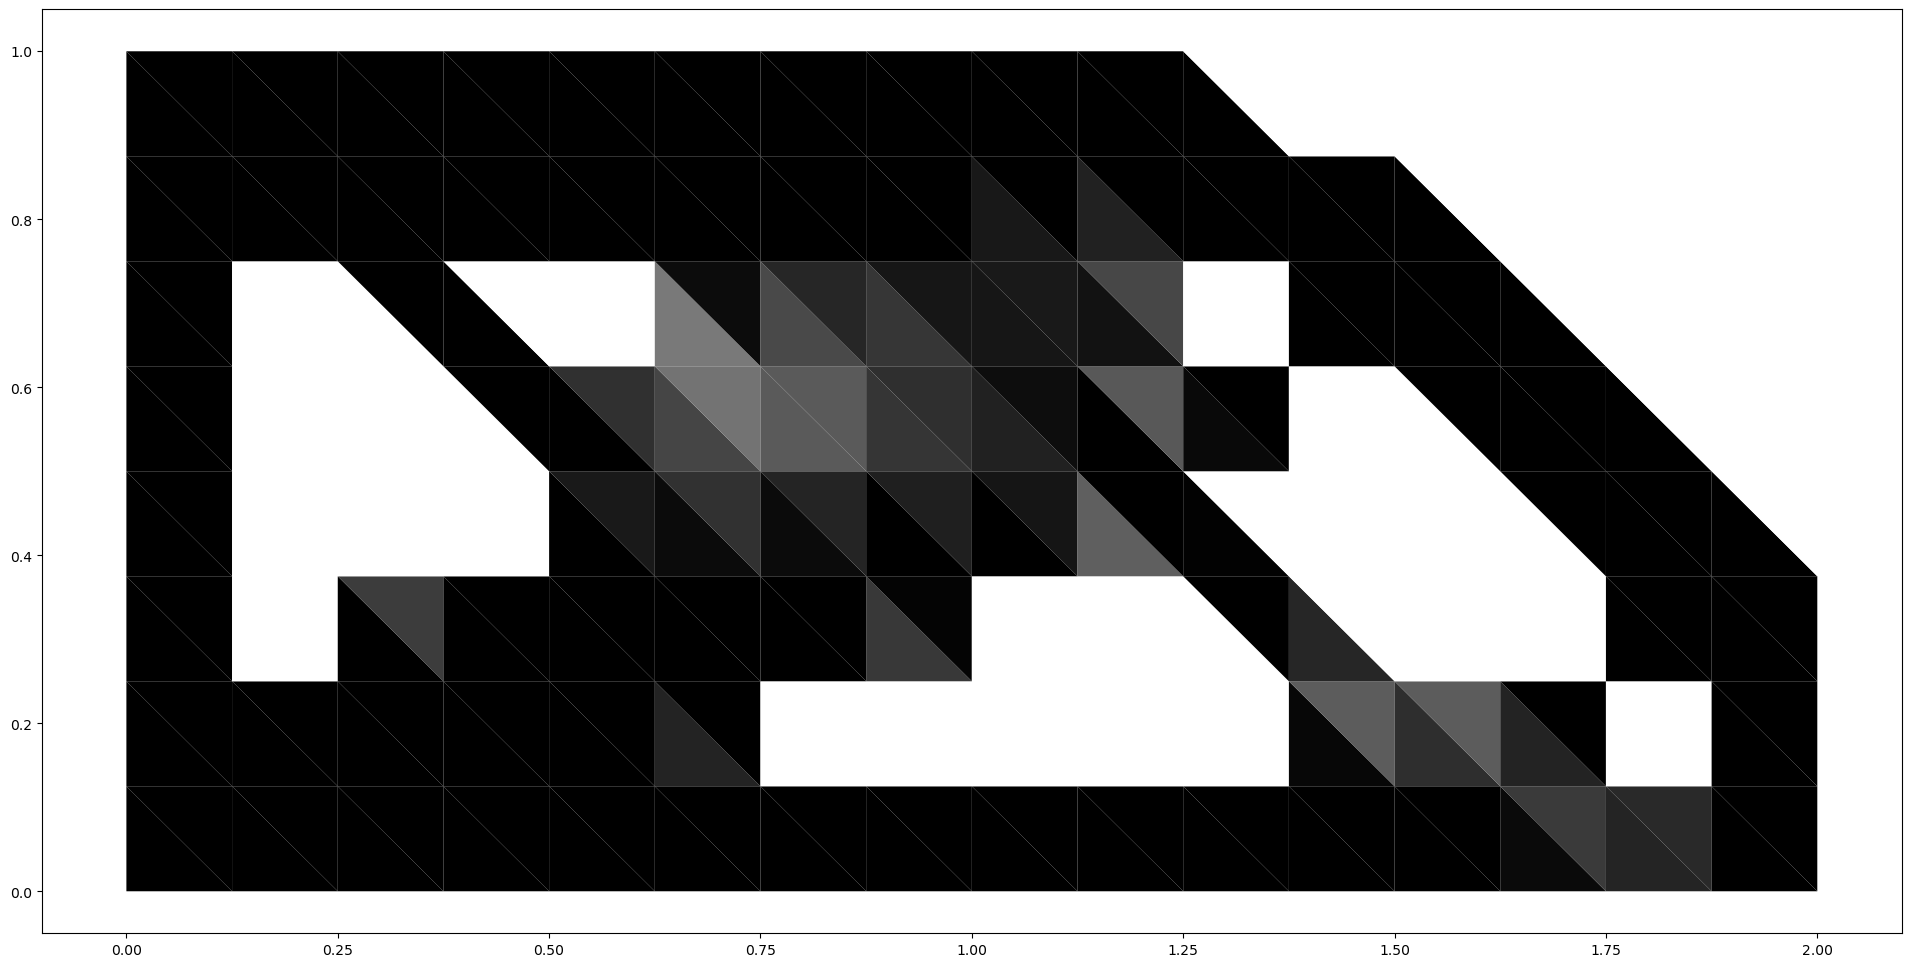

In [11]:
rho_steep = np.ones(nelem)
rho_steep[free] = solopt
mesh.displayDiscontinuousByElementField(1-rho_steep)

In [12]:
elas_solver._nAssembly

64

In [13]:
elas_solver._nResolution

64